In [1]:
import tvm
from tvm.ir.module import IRModule
from tvm.script import tir as T, relax as R
import matplotlib.pyplot as plt
import numpy as np
from tvm import relax
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations 

In [85]:
dtype = "float32"
l1 = np.loadtxt("weights/dense.csv", delimiter=",").astype(dtype)
l1 = l1.transpose(1, 0)
print("linear1", l1.shape)
b1 = np.loadtxt("weights/bias.csv", delimiter=",").astype(dtype)
print("bias1", b1.shape)
l2 = np.loadtxt("weights/dense_1.csv", delimiter=",").astype(dtype)
l2 = l2.transpose(1, 0)
print("linear2", l2.shape)
b2 = np.loadtxt("weights/bias_1.csv", delimiter=",").astype(dtype)
print("bias1", b2.shape)

linear1 (512, 784)
bias1 (512,)
linear2 (10, 512)
bias1 (10,)


In [60]:
@tvm.script.ir_module
class MyModule: 
    @T.prim_func
    def relu(X: T.Buffer[(1, 512), "float32"], 
             Y: T.Buffer[(1, 512), "float32"]):
        # function attr dict
        T.func_attr({"global_symbol": "relu", "tir.noalias": True})
        for i, j in T.grid(1, 512):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))

    @T.prim_func
    def linear1(X: T.Buffer[(1, 784), "float32"], 
                W: T.Buffer[(512, 784), "float32"], 
                B: T.Buffer[(512,), "float32"], 
                Z: T.Buffer[(1, 512), "float32"]):
        T.func_attr({"global_symbol": "linear1", "tir.noalias": True})
        Y = T.alloc_buffer((1, 512), "float32")
        for i, j, k in T.grid(1, 512, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
    
        for i, j in T.grid(1, 512):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @T.prim_func
    def linear2(X: T.Buffer[(1, 512), "float32"], 
                W: T.Buffer[(10, 512), "float32"], 
                B: T.Buffer[(10,), "float32"], 
                Z: T.Buffer[(1, 10), "float32"]):
        T.func_attr({"global_symbol": "linear2", "tir.noalias": True})
        Y = T.alloc_buffer((1, 10), "float32")
        for i, j, k in T.grid(1, 10, 512):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
    
        for i, j in T.grid(1, 10):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @R.function
    def main(x: Tensor((1, 784), "float32"), 
             w0: Tensor((512, 784), "float32"), 
             b0: Tensor((512,), "float32"), 
             w1: Tensor((10, 512), "float32"), 
             b1: Tensor((10,), "float32")):
        with R.dataflow():
            lv0 = R.call_tir(linear1, (x, w0, b0), (1, 512), dtype="float32")
            lv1 = R.call_tir(relu, (lv0,), (1, 512), dtype="float32")
            out = R.call_tir(linear2, (lv1, w1, b1), (1, 10), dtype="float32")
            R.output(out)
        return out

In [62]:
@R.function
def main(x: Tensor((1, 784), "float32"), 
            w0: Tensor((512, 784), "float32"), 
            b0: Tensor((512,), "float32"), 
            w1: Tensor((10, 512), "float32"), 
            b1: Tensor((10,), "float32")):
    with R.dataflow():
        lv0 = R.call_tir(linear1, (x, w0, b0), (1, 512), dtype="float32")
        lv1 = R.call_tir(relu, (lv0,), (1, 512), dtype="float32")
        out = R.call_tir(linear2, (lv1, w1, b1), (1, 10), dtype="float32")
        R.output(out)
    return out

In [63]:
MyModule.show()

In [4]:
from skimage import io, color

In [6]:
def read_image(path):
  image = io.imread(path)
  return image

def display_image(data):
  plt.figure()
  if len(data.shape) == 3:
    plt.imshow(data)
  else:
    plt.imshow(data[:, :], cmap=plt.cm.gray)

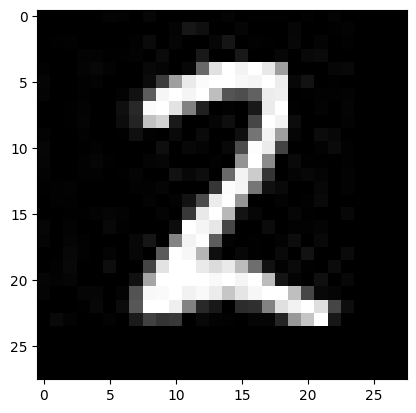

In [7]:
class_names = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
test_image_choice = '2'
image_path = "img/mnist_img_{}.jpg".format(test_image_choice)
image = read_image(image_path)
display_image(image)

In [98]:
image = image.reshape(1, 28*28)
print(image.shape)

(1, 784)


In [99]:
image = image.astype(dtype) / 255

In [100]:
ex = relax.vm.build(MyModule, target="llvm")
type(ex)

tvm.relax.vm.Executable

In [101]:
vm = relax.VirtualMachine(ex, tvm.cpu())

In [102]:
mlp_params = {}
mlp_params["w0"] = l1
mlp_params["b0"] = b1
mlp_params["w1"] = l2
mlp_params["b1"] = b2

In [103]:
data_nd = tvm.nd.array(image)
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

In [106]:
nd_res = vm["main"](data_nd, 
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])
nd_res
pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("Predicted number: {}".format(class_names[pred_kind[0]]))

Predicted number: 2
